In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from graphnet import *
from configobj import ConfigObj
from Dataset import *
import matplotlib.pyplot as plt


In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Set device to GPU 0 if available, otherwise CPU
device = torch.device("cuda:0" if cuda_available else "cpu")
gpu = 0

# Print device info
print(f"CUDA available: {cuda_available}")
print(f"Using device: {device}")

CUDA available: True
Using device: cuda:0


In [3]:
#  LOAD THE DATACUBES OF THE GRID FROM C PORTA CODE

datadir = '../data_porta'
# ---- grid dimensions taken from the C code ----
nx = ny = 504
nz = 476 - 52 + 1          # 425
nlev = 6                   # caii[0] … caii[5]

# ---- memory–mapped array: reads only the chunks you touch ----
pops = np.memmap(
    f'{datadir}/AR_385_CaII_5L_pops.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, nlev)   # (k, j, i, level)==(z, y, x, L)
)

# ---- memory–mapped array: reads only the chunks you touch ----
b_xyz = np.memmap(
    f'{datadir}/AR_385_B.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 3)   # (k, j, i, B_i)==(z, y, x, B)
)

# ---- memory–mapped array: reads only the chunks you touch ----
temp = np.memmap(
    f'{datadir}/AR_385_temp.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
vel = np.memmap(
    f'{datadir}/AR_385_veloc.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 3)   # (k, j, i, 3)==(z, y, x, 3)
)

# ---- memory–mapped array: reads only the chunks you touch ----
n_e = np.memmap(
    f'{datadir}/AR_385_ne.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
n_p = np.memmap(
    f'{datadir}/AR_385_np.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
n_h = np.memmap(
    f'{datadir}/AR_385_nh.dat',
    dtype='<f4',           # little-endian 32-bit float
    mode='r',
    shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
)

# ---- memory–mapped array: reads only the chunks you touch ----
# geom = np.memmap(
#     f'{datadir}/AR_385_GEOMETRY.dat',
#     dtype='<f4',           # little-endian 32-bit float
#     mode='r',
#     shape=(nz, ny, nx, 1)   # (k, j, i, 1)==(z, y, x, 1)
# )

In [4]:
print('Populations shape:\t', pops.shape)
print('Temperature shape:\t', temp.shape)
print('Mag, field shape:\t', b_xyz.shape)
print('Velocity shape:\t\t', vel.shape)
print('N_elec shape:\t\t', n_e.shape)
print('N_nh shape:\t\t', n_h.shape)
print('N_p shape:\t\t', n_p.shape)

from scipy.interpolate import interpn

# Define a new, higher-resolution grid
z, y, x = (np.arange(d) for d in (nz, ny, nx))

new_nz, new_ny, new_nx = 128, nx, ny
new_z, new_y, new_x = (np.linspace(0, d-1, new_d) for d, new_d in zip((nz,ny,nx), (new_nz,new_ny,new_nx)))
new_zv, new_yv, new_xv = np.meshgrid(new_z, new_y, new_x, indexing='ij', sparse=True)

# print('\n')
# print(f'original indices: {z}')
# print(f'new indices: {new_z}')

# Interpolate data onto the new grid
new_points = (new_zv, new_yv, new_xv)
pops_interp = interpn((z, y, x), pops, new_points)
temp_interp = interpn((z, y, x), temp, new_points)
b_xyz_interp = interpn((z, y, x), b_xyz, new_points)
vel_interp = interpn((z, y, x), vel, new_points)
n_e_interp = interpn((z, y, x), n_e, new_points)
n_h_interp = interpn((z, y, x), n_h, new_points)
n_p_interp = interpn((z, y, x), n_p, new_points)

print('\n'+'#'*60)
print('Populations shape INTERPOLATED:\t', pops_interp.shape)
print('Temperature shape INTERPOLATED:\t', temp_interp.shape)
print('Mag, field shape INTERPOLATED:\t', b_xyz_interp.shape)
print('Velocity shape INTERPOLATED:\t', vel_interp.shape)
print('N_elec shape INTERPOLATED:\t', n_e_interp.shape)
print('N_nh shape INTERPOLATED:\t', n_h_interp.shape)
print('N_p shape INTERPOLATED:\t\t', n_p_interp.shape)

Populations shape:	 (425, 504, 504, 6)
Temperature shape:	 (425, 504, 504, 1)
Mag, field shape:	 (425, 504, 504, 3)
Velocity shape:		 (425, 504, 504, 3)
N_elec shape:		 (425, 504, 504, 1)
N_nh shape:		 (425, 504, 504, 1)
N_p shape:		 (425, 504, 504, 1)

############################################################
Populations shape INTERPOLATED:	 (128, 504, 504, 6)
Temperature shape INTERPOLATED:	 (128, 504, 504, 1)
Mag, field shape INTERPOLATED:	 (128, 504, 504, 3)
Velocity shape INTERPOLATED:	 (128, 504, 504, 3)
N_elec shape INTERPOLATED:	 (128, 504, 504, 1)
N_nh shape INTERPOLATED:	 (128, 504, 504, 1)
N_p shape INTERPOLATED:		 (128, 504, 504, 1)


In [5]:
pops = pops_interp
temp = temp_interp
b_xyz = b_xyz_interp
vel = vel_interp
n_e = n_e_interp
n_h = n_h_interp
n_p = n_p_interp

In [6]:
# Read the configuration file
config_file = 'conf.dat'
with open(config_file, 'r') as f:
    tmp = f.readlines()
    f.close()

    # Parse configuration file and transform to integers
    hyperparameters = ConfigObj(tmp)

for k, q in hyperparameters.items():
    hyperparameters[k] = int(q)

# Instantiate the model with the hyperparameters
model = EncodeProcessDecode(**hyperparameters).to(device)
# Print the number of trainable parameters
print('N. total trainable parameters : {0}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))


N. total trainable parameters : 5460038


In [7]:
datast = EfficientDataset([vel/vel.mean(), b_xyz/b_xyz.mean(), temp/temp.mean(), np.log10(n_h/n_h.mean()), np.log10(n_e/n_e.mean()), np.log10(n_p/n_p.mean())],
                          [pops/pops.sum(axis=-1, keepdims=True)],
                          radius_neighbors=1.77)
# Get a single sample graph
sample_graph = datast[0].to(device)

# Now, provide the input as a tuple of tensors
batch_tensor = torch.zeros(sample_graph.num_nodes, dtype=torch.long).to(device)

Dataset created. Features shape: (32514048, 10), Targets shape: (32514048, 6)


In [8]:
sample_graph

Data(x=[1152, 10], y=[1152, 6], pos=[1152, 3], edge_index=[2, 17566], edge_attr=[17566, 1], u=[1, 1])

In [9]:
torch.unique(sample_graph.edge_attr)

tensor([1.0000, 1.4142, 1.7321], device='cuda:0')

In [10]:
print("Model device:", next(model.parameters()).device)
print("sample_graph.x device:", sample_graph.x.device)
print("sample_graph.edge_attr device:", sample_graph.edge_attr.device)
print("sample_graph.edge_index device:", sample_graph.edge_index.device)
print("sample_graph.u device:", sample_graph.u.device)
print("batch_tensor device:", batch_tensor.device)

Model device: cuda:0
sample_graph.x device: cuda:0
sample_graph.edge_attr device: cuda:0
sample_graph.edge_index device: cuda:0
sample_graph.u device: cuda:0
batch_tensor device: cuda:0


In [11]:
print(model)

EncodeProcessDecode(
  (edge_encoder): MLP(
    (activation): ELU(alpha=1.0)
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (node_encoder): MLP(
    (activation): ELU(alpha=1.0)
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (encoder_network): GraphIndependent(
    (edge_model_fn): MLP(
      (activation): ELU(alpha=1.0)
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=True)
 

In [12]:
model = model.to(device)
param_size = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
total_size = param_size + buffer_size

print(f"Model size: {total_size / 1024 ** 2:.2f} MB")


Model size: 20.83 MB


In [13]:
loader = DataLoader( datast, batch_size=8, shuffle=False)

In [14]:
lr = 1e-3
n_epochs = 10
savedir = 'checkpoints/'
smooth = 0.05

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Cosine annealing learning rate scheduler. This will reduce the learning rate with a cosing law
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

# Loss function
loss_fn = nn.MSELoss()

# Now start the training
train_loss = []
valid_loss = []
best_loss = float('inf')

# print(torch.cuda.memory_summary())

for epoch in range(1, n_epochs + 1):

    filename = str(epoch) #time.strftime("%Y%m%d-%H%M%S")

    # Compute training and validation steps
    ################### TRAINING ###################
    # Put the model in training mode
    model.train()
    print("Epoch {0}/{1}".format(epoch, n_epochs))
    t = tqdm(loader)
    loss_avg = 0.0

    for batch_idx, (data) in enumerate(t):

        # Extract the node, edges, indices, target, global and batch information from the Data class
        node = data.x
        edge_attr = data.edge_attr
        edge_index = data.edge_index
        target = data.y
        u = data.u
        batch = data.batch

        # Move them to the GPU
        node, edge_attr, edge_index = node.to(device), edge_attr.to(device), edge_index.to(device)
        u, batch, target = u.to(device), batch.to(device), target.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Evaluate Graphnet
        out = model(node, edge_attr, edge_index, u, batch)

        # Compute loss
        loss = loss_fn(out.squeeze(), target.squeeze())

        # Compute backpropagation
        loss.backward()

        # Update the parameters
        optimizer.step()

        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']

        # Compute smoothed loss
        if (batch_idx == 0):
            loss_avg = loss.item()
        else:
            loss_avg = smooth * loss.item() + (1.0 - smooth) * loss_avg

        # free gpu memory
        # torch.cuda.empty_cache()

    train_loss.append(loss_avg)

    ################### VALIDATION ###################
    # Do a validation of the model and return the loss

    model.eval()
    loss_avg = 0
    t = tqdm(loader)
    with torch.no_grad():
        for batch_idx, (data) in enumerate(t):

            node = data.x
            edge_attr = data.edge_attr
            edge_index = data.edge_index
            target = data.y
            u = data.u
            batch = data.batch

            node, edge_attr, edge_index = node.to(device), edge_attr.to(device), edge_index.to(device)
            u, batch, target = u.to(device), batch.to(device), target.to(device)

            out = model(node, edge_attr, edge_index, u, batch)

            loss = loss_fn(out.squeeze(), target.squeeze())

            if (batch_idx == 0):
                loss_avg = loss.item()
            else:
                loss_avg = smooth * loss.item() + (1.0 - smooth) * loss_avg

            t.set_postfix(loss=loss_avg)

    valid_loss.append(loss_avg)

    # If the validation loss improves, save the model as best
    if (valid_loss[-1] < best_loss):
        best_loss = valid_loss[-1]

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'best_loss': best_loss,
            'hyperparameters': hyperparameters,
            'optimizer': optimizer.state_dict(),
        }

        print("Saving best model...")
        torch.save(checkpoint, savedir + filename + '_best.pth')

    # Update the learning rate
    scheduler.step()


Epoch 1/10


100%|██████████| 125/125 [00:22<00:00,  5.58it/s, loss=0.0572]


Saving best model...
Epoch 2/10


100%|██████████| 125/125 [00:22<00:00,  5.65it/s, loss=0.0295]


Saving best model...
Epoch 3/10


100%|██████████| 125/125 [00:22<00:00,  5.65it/s, loss=0.0322]


Epoch 4/10


100%|██████████| 125/125 [00:21<00:00,  5.71it/s, loss=0.0188]


Saving best model...
Epoch 5/10


100%|██████████| 125/125 [00:21<00:00,  5.68it/s, loss=0.0139]


Saving best model...
Epoch 6/10


100%|██████████| 125/125 [00:21<00:00,  5.71it/s, loss=0.0126]


Saving best model...
Epoch 7/10


100%|██████████| 125/125 [00:21<00:00,  5.72it/s, loss=0.0127]


Epoch 8/10


100%|██████████| 125/125 [00:21<00:00,  5.70it/s, loss=0.0116]


Saving best model...
Epoch 9/10


100%|██████████| 125/125 [00:22<00:00,  5.66it/s, loss=0.0114]


Saving best model...
Epoch 10/10


100%|██████████| 125/125 [00:22<00:00,  5.67it/s, loss=0.011] 


Saving best model...


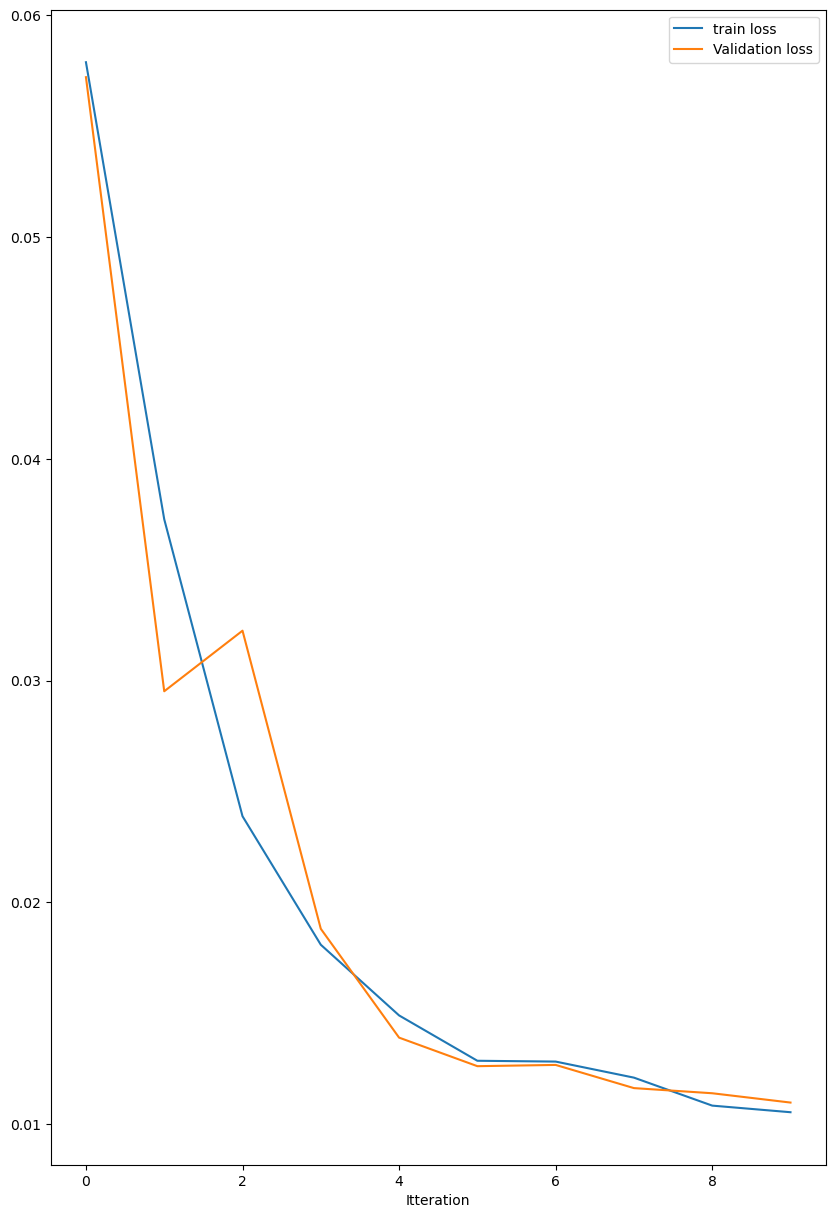

In [15]:
plt.figure(0, (10,15), dpi=100)
plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='Validation loss')
plt.xlabel('Itteration')
plt.legend()
plt.show()
